In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


# Reading Dataset

In [3]:
# Read the dataset
raw = pd.read_csv('/nas.dbms/mahendra.data/Documents/annotation/NAB/data/realKnownCause/nyc_taxi.csv',low_memory=False)
raw['timestamp'] = pd.to_datetime(raw['timestamp'])


# The times of anomaly events (Ground Truth)
anomaly_points = [
        [
            "2014-10-30 15:30:00.000000",
            "2014-11-03 22:30:00.000000"
        ],
        [
            "2014-11-25 12:00:00.000000",
            "2014-11-29 19:00:00.000000"
        ],
        [
            "2014-12-23 11:30:00.000000",
            "2014-12-27 18:30:00.000000"
        ],
        [
            "2014-12-29 21:30:00.000000",
            "2015-01-03 04:30:00.000000"
        ],
        [
            "2015-01-24 20:30:00.000000",
            "2015-01-29 03:30:00.000000"
        ]
]

# Labeling: if anomaly then 1 else 0
raw['anomaly'] = 1  # Set default values
for start, end in anomaly_points:
    raw.loc[((raw['timestamp'] >= start) & (raw['timestamp'] <= end)), 'anomaly'] = -1

# Preview labeled raw dataset
raw

,timestamp,value,anomaly
0,2014-07-01 00:00:00,10844,1
1,2014-07-01 00:30:00,8127,1
2,2014-07-01 01:00:00,6210,1
3,2014-07-01 01:30:00,4656,1
4,2014-07-01 02:00:00,3820,1
...,...,...,...
10315,2015-01-31 21:30:00,24670,1
10316,2015-01-31 22:00:00,25721,1
10317,2015-01-31 22:30:00,27309,1
10318,2015-01-31 23:00:00,26591,1


In [4]:
raw['anomaly'].value_counts()

 1    9285
-1    1035
Name: anomaly, dtype: int64

# Preprocessing

In [5]:
# Convert the timestamp
df = pd.DataFrame()
df['year'] = raw['timestamp'].dt.year
df['month'] = raw['timestamp'].dt.month
df['day'] = raw['timestamp'].dt.day
df['hour'] = raw['timestamp'].dt.hour
df['value'] = raw['value']
df['anomaly'] = raw['anomaly']

# delete unused dataframe
del raw

In [6]:
# Preview dataset
df

,year,month,day,hour,value,anomaly
0,2014,7,1,0,10844,1
1,2014,7,1,0,8127,1
2,2014,7,1,1,6210,1
3,2014,7,1,1,4656,1
4,2014,7,1,2,3820,1
...,...,...,...,...,...,...
10315,2015,1,31,21,24670,1
10316,2015,1,31,22,25721,1
10317,2015,1,31,22,27309,1
10318,2015,1,31,23,26591,1


In [7]:
# Calculate 80% of the number of rows for training
num_rows = int(0.8 * len(df))

# Get the first part of the DataFrame
df_train = df[:num_rows]
# Get the remaining part of the DataFrame
df_test = df[num_rows:]

# delete unused dataframe
del df

In [8]:
df_train['anomaly'].value_counts()

 1    7842
-1     414
Name: anomaly, dtype: int64

In [9]:
df_test['anomaly'].value_counts()

 1    1443
-1     621
Name: anomaly, dtype: int64

# Helper Functions

In [10]:
def plot_cm(cm):
    plt.close()
    # plt.figure(figsize=(8,8))
    # sns.set(font_scale = 1.5)

    ax = sns.heatmap(
        cm, # confusion matrix 2D array 
        annot=True, # show numbers in the cells
        fmt='d', # show numbers as integers
        xticklabels=[-1,1],
        yticklabels=[-1,1],
        # cbar=False, # don't show the color bar
        # cmap='flag', # customize color map
        # vmin=200, # to get better color contrast
        # vmax=800 # to get better color contrast
    )

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.show()


def show_matrix(y, y_pred):
    ps = precision_score(y, y_pred, pos_label=-1, labels=[-1, 1])
    print("precision_score: %.2f" % ps)

    rs = recall_score(y, y_pred, pos_label=-1, labels=[-1, 1])
    print("recall_score: %.2f" % rs)

    f1 = f1_score(y, y_pred, pos_label=-1, labels=[-1, 1])
    print("f1_score: %.2f" % f1)

    cm = confusion_matrix(y, y_pred, labels=[-1, 1])
    # print("conf_matrix")
    # print(cm)
    plot_cm(cm)

# IsolationForest

In [11]:
# X_train = df_train[['value']].to_numpy()
X_train = df_train.drop(columns='anomaly').to_numpy()
y_train = df_train['anomaly'].to_numpy()

# X_test = df_test[['value']].to_numpy()
X_test = df_test.drop(columns='anomaly').to_numpy()
y_test = df_test['anomaly'].to_numpy()

Train
precision_score: 0.07
recall_score: 0.94
f1_score: 0.13


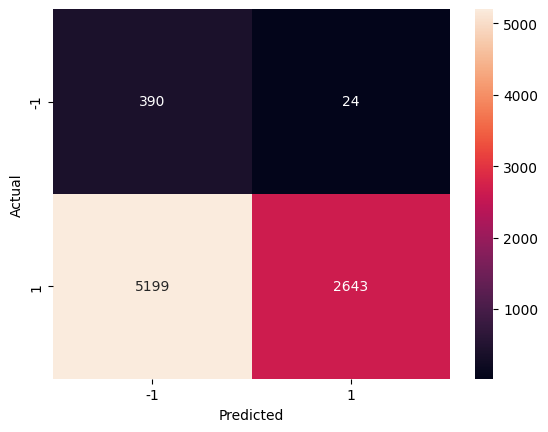

Test
precision_score: 0.34
recall_score: 0.99
f1_score: 0.50


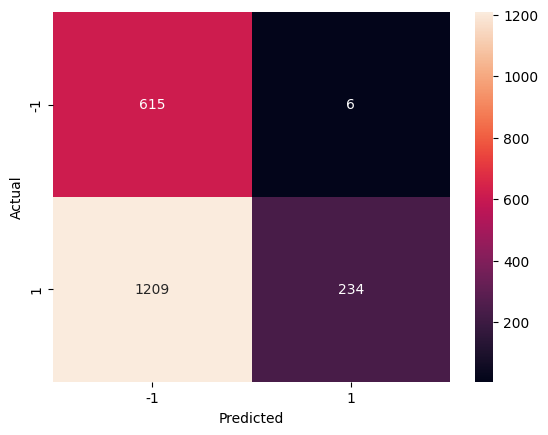

In [12]:
from sklearn.ensemble import IsolationForest

# Fit the Isolation Forest model
clf = IsolationForest(n_estimators=200)
clf.fit(X_train)

# Predict the anomalies
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Train")
show_matrix(y_train, y_pred_train)

print("Test")
show_matrix(y_test, y_pred_test)


# LocalOutlierFactor

Train
precision_score: 0.13
recall_score: 0.01
f1_score: 0.02


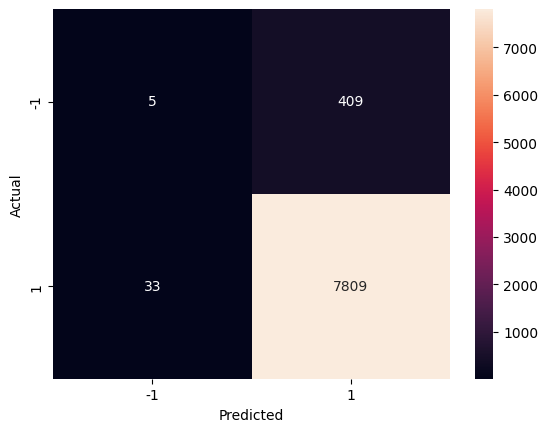

Test
precision_score: 0.61
recall_score: 0.04
f1_score: 0.08


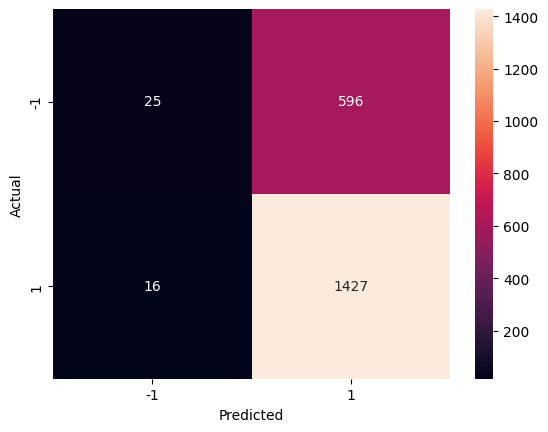

In [13]:
from sklearn.neighbors import LocalOutlierFactor

# Fit the Local Outlier Factor model
clf = LocalOutlierFactor(n_neighbors=200)
y_pred_train = clf.fit_predict(X_train)

# Generate some test data
y_pred_test = clf.fit_predict(X_test)

print("Train")
show_matrix(y_train, y_pred_train)

print("Test")
show_matrix(y_test, y_pred_test)


In [14]:
y_pred_test

array([ 1,  1,  1, ..., -1,  1,  1])

# OneClassSVM

Train
precision_score: 0.05
recall_score: 0.72
f1_score: 0.10


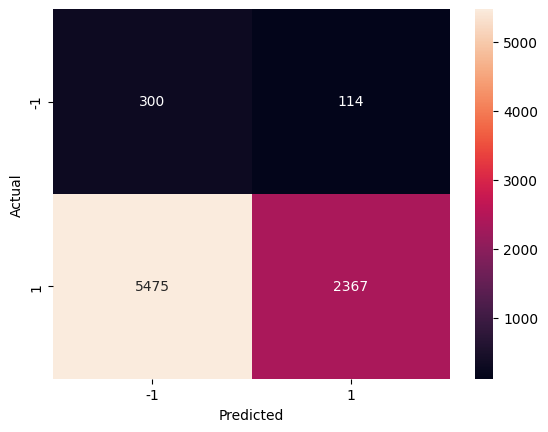

Test
precision_score: 0.30
recall_score: 1.00
f1_score: 0.46


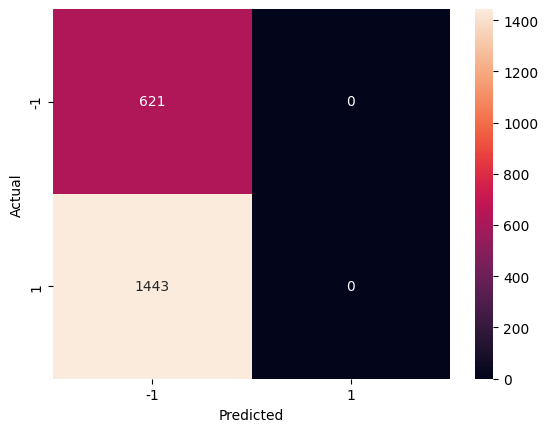

In [15]:
from sklearn.svm import OneClassSVM

# Fit the One-Class SVM model
clf = OneClassSVM(gamma='auto')
clf.fit(X_train)

# Predict the outliers
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Train")
show_matrix(y_train, y_pred_train)

print("Test")
show_matrix(y_test, y_pred_test)
